##Setup

In [55]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle
import gzip
import torch
from torch import tensor
from torch import nn
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')
datasets_path='/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Tópicos estudados do livro *Neural Networks and Deep Learning*:

*   Using neural nets to recognize handwritten digits
*   How the backpropagation algorithm works
*   Improving the way neural networks learn





##1. Expansão dos modelos lineares para as redes neurais

A unidade básica das redes neurais são os *neurônios* artificiais, levemente inspirados nos neurônios do cérebro. Neurônios artificiais, de modo similar aos perceptrons, aceitam entradas $x_1, x_2, \dots, x_n$ e, por meio de pesos $w_1, w_2, \dots, w_n$ para cada entrada entrada e um viés $b$, gera uma saída $0$ ou $1$. Porém, o problema de perceptrons simples para redes neurais é que fica difícil realizar as pequenas mudanças necessárias em pesos e vieses, já que elas podem gerar grandes mudanças nas saídas. Assim, usamos os neurônios sigmoides para tarefas do tipo, já que eles garantem pequenas mudanças de saída para pequenas mudanças de pesos e viés. Um neurônio sigmoide é similar perceptron, mas, em vez de gerar a saída diretamente de $w\cdot x + b$, ele gera um saída com a função $\sigma(z)$, chamada de função sigmoide, de modo que
\begin{align*}
\sigma(z)&=\sigma\biggl(\frac{1}{1+e^{-z}}\biggr)\\
&=\frac{1}{1+\exp(-\sum_j w_jx_j - b)},
\end{align*}
com saída entre $0$ e $1$. Podemos interpretar isso como uma probabilidade, assim como o caso da regressão logística. Note também que $\sigma'(z)=\sigma(z)(1-\sigma(z))=\frac{e^{-z}}{(1+e^{-z})^2}$

A função sigmoide está representada abaixo.

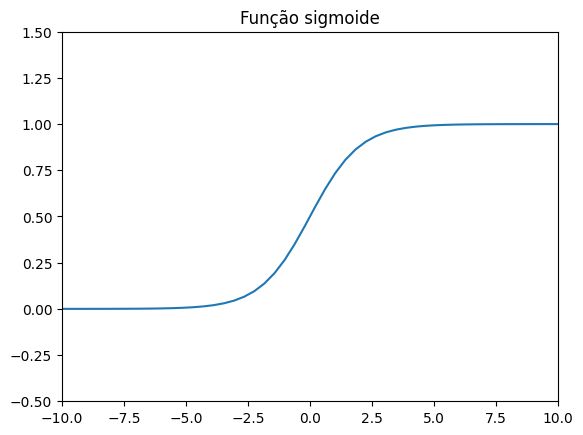

In [23]:
xx = np.linspace(-10, 10)
plt.title("Função sigmoide")
plt.xlim(-10, 10)
plt.ylim(-0.5, 1.5)
plt.plot(xx, 1 / (1 + np.exp(-xx)))

Uma rede neural corresponde a vários desses neurônios sigmoides conectados entre si por pesos e com vieses associados em múltiplas camadas. Os neurônios da camada de entrada são correspondentes aos dados de entrada, sem vieses associados, e com pesos individuais de cada neurônio dessa camada para cada um da próxima camada. As camadas de saída são correspondentes aos neurônios finais com as saídas geradas a partir da rede neural. As camadas "escondidas" são aquelas que não são nem de entrada e nem de saída, sendo que os neurônios de uma camada escondida específica recebem entradas com a aplicação dos pesos de cada neurônio da camada anterior e, junto do viés associado a cada neurônio individual da camada atual, geram saídas por meio da função sigmoide. Cada saída também é conectada aos neurônios da camada seguinte através da aplicação dos pesos da camada atual. Em nossos exemplos, usaremos o conjunto de dados MNIST, que consiste em imagens de dígitos e seus algarismos correspondentes como alvos. Cada imagem é $28\times 28$, então podemos usar $28\cdot 28=784$ neurônios de entrada, ou seja, um vetor de $784$ elementos, que representa a intensidade de cinza de cada pixel. O alvo é um vetor de $10$ elementos com apenas uma posição igual a $1$ e todas as outras iguais a $0$, de modo que o índice (começando de $0$) de uma posição igual a $1$ corresponde ao algarismo correspondente àquele representado na imagem ($y(x)=(0,0,1,0,0,0,0,0,0,0)^T$, para alguma entrada $x$, corresponde ao dígito alvo $2$, por exemplo).

Apresentamos agora um exemplo de função de custo ou erro que usaremos:
\begin{align*}
C(w,b)=\frac{1}{2n}\sum_x ||y(x)-a||^2,
\end{align*}
em que $w$ é todo peso da rede, $b$ todo viés, $n$ o número de amostras de treinamento, $y$ o alvo da entrada $x$ e $a$ o vetor de saídas da rede a partir de $x$ também, além de $w$ e $b$. Chamamos $C$ de função de custo quadrático ou erro quadrático médio. Como os modelos lineares, o objetivo dos algoritmos de redes neurais é minimizar $C$ e, para isso, também é possível utilizar o método do gradiente descendente. Seja $\Delta C$ a mudança em $C$. Seja $v=(v_1,v_2,\dots,v_m)^T$ a entrada da função $C$. Pela regra da cadeia do Cálculo de múltiplas variáveis, sabemos que
\begin{align*}
\Delta C &\approx \frac{\delta C}{\delta v_1}\Delta v_1 + \frac{\delta C}{\delta v_2}\Delta v_2 + \dots + \frac{\delta C}{\delta v_m}\Delta v_m
&= \nabla C \cdot \Delta v,
\end{align*}
em que \Delta v_i representa uma mudança na direção do vetor $v_i$, para $i\in {1,\dots,m}$, $\nabla C = \biggl(\frac{\delta C}{\delta v_1},\dots, \frac{\delta C}{\delta v_m}\biggr)^T$ e $\Delta v=(\Delta v_1, \dots, \Delta v_m)^T$. Suponha, similarmente à regressão logística, que escolhemos $\Delta v = -\eta\nabla C$ ($\eta$ é chamada de taxa de aprendizado). Dessa forma, $\Delta C\approx -\eta\nabla C\cdot \nabla C=-\eta||\nabla C||^2$ e, em nossos algoritmos, podemos fazer $v\gets v'=v-\eta\nabla C$. Em termos dos pesos $w_k$ e vieses $b_l$, poderíamos fazer
\begin{align*}
w_k&\gets w_k'=w_k-\eta\frac{\delta C}{\delta w_k}\\
b_l&\gets b_l'=b_l-\eta\frac{\delta C}{\delta b_l}.
\end{align*}

##2. O algoritmo de backpropagation

Para computar $\frac{\delta C}{\delta w_k}$ e $\frac{\delta C}{\delta b_l}$ rapidamente, utilizamos o chamado algoritmo de *backpropagation*. Antes de apresentá-lo, devemos introduzir notações úteis.

###2.1. Notação matricial
Seja $w_{jk}^l$ o peso para a conexão do $k$-ésimo neurônio na $(l-1)$-ésima camada para o $j$-ésimo neurônio na $l$-ésima camada. De modo similar, seja $b_j^l$ o viés do $j$-ésimo neurônio na $l$-ésima camada. Por fim, seja $a_j^l$ a *ativação* ou saída do $j$-ésimo neurônio da $l$-ésima camada, dependente da ativação da camada anterior (a camada $l-1$), de modo que
\begin{align*}
a_j^l=\sigma\biggl(\sum_k w_{jk}^l a_k^{l-1} + b_j^l \biggr),
\end{align*}
sendo que a soma é sobre todos os neurônios $k$ da $(l-1)$-ésima camada. Na notação matricial, definimos uma matriz $w^l$ para cada camada $l$, em que o elemento na $j$-ésima linha e $k$-ésima coluna corresponde a $w_{jk}^l$. Do mesmo modo, definimos o vetor $b^l$, em que o elemento da $j$-ésima linha corresponde a $b_j^l$ e, por fim, definimos o vetor $a^l$, em que o elemento da $j$-ésima linha corresponde a $a_j^l$. Assim, podemos escrever agora $a^l$ como
\begin{align*}
a^l=\sigma(w^l a^{l-1} + b^l).
\end{align*}

###2.2. As equações de backpropagation e suas provas
Para calcular $\frac{\delta C}{\delta w_{jk}^l}$ e $\frac{\delta C}{\delta b_j^l}$, precisamos definir $\delta_j^l$, o erro no $j$-ésimo neurônio da $l$-ésima camada. Para isso, considere que, com uma pequena mudança $\Delta z_k^l$ na entrada do neurônio associado, temos agora, em vez de $\sigma(z_k^l)$ como saída, $\sigma(z_k^l+\Delta z_k^l)$. Essa mudança propaga sobre a rede neural na etapa de alimentação dela com as entradas (etapa chamada de *feedforward*), e o custo, no geral, muda em $\frac{\delta C}{\delta z_j^l}\Delta z_j^l$. Nesse contexto, consideramos o primeiro operando da multiplicação como uma medida de erro e denotamos ela por $\delta_j^l=\frac{\delta C}{\delta z_j^l}$.

**Primeira equação — erro na camada de saída, $\delta^L$:**

$\delta_j^L$ pode ser denotado por
\begin{align*}
\delta_j^L=\frac{\delta C}{\delta a_j^L}\sigma'(z_j^L).
\end{align*}
Em notação matricial, podemos denotá-la por
\begin{align*}
\delta^L=\nabla_a C \odot \sigma'(z^L),
\end{align*}
sendo que $\nabla_a C=\biggl(\frac{\delta C}{\delta a_1^L},\dots, \frac{\delta C}{\delta a_m^L} \biggr)^T$, para todos os $m$ neurônios na $L$-ésima camada (que é a camada de saída). Utilizamos a multiplicação de Hadamard $\odot$ porque a equação vista antes corresponde à multiplicação de cada par de elementos de $\nabla_a C$ e $\sigma'(z^L)$. Para a função $C$ escolhida, sabemos que $\nabla_a C=(a^L-y)$, ou seja,
\begin{align*}
\delta^L=(a^L-y)\odot \sigma'(z^L).
\end{align*}

***Prova:*** aplicando a regra da cadeia em $\delta_j^L=\frac{\delta C}{\delta z_j^L}$, obtemos
\begin{align*}
\delta_j^L=\sum_k \frac{\delta C}{\delta a_k^L} \frac{\delta a_k^L}{\delta z_j^L},
\end{align*}
sendo que a soma é sobre todos os neurônios $k$ da camada de saída. A ativação $a_k^L$ depende apenas de $z_j^L$ para o $j$-ésimo neurônio quando $k=j$, ou seja, $\frac{\delta a_k^L}{\delta z_j^L}$ é zero quando $k\neq j$. Assim,
\begin{align*}
\delta_j^L&=\frac{\delta C}{\delta a_j^L}\frac{\delta a_j^L}{\delta z_j^L}\\
&=\frac{\delta C}{\delta a_j^L} \sigma'(z_j^L),
\end{align*}
sabendo que $a_j^L=\sigma(z_j^L)$ e $\sigma'(z_j^L)=\frac{\delta a_j^L}{\delta z_j^L}$.

**Segunda equação — erro na camada $l$, $\delta^l$, em termos do erro na próxima camada, $\delta^{l+1}$:**

Sabendo o erro $\delta^{l+1}$, podemos descobrir o erro na camada anterior, $\delta^l$:
\begin{align*}
\delta^l=((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l).
\end{align*}

***Prova:*** é possível diferenciar $\delta_j^l=\frac{\delta C}{\delta z_j^l}$ em função de $z_k^{l+1}$ para os neurônios $k$ na camada seguinte. Lembre-se que $C$ tem relação com os resultados da camada de saída, então essa diferenciação leva a um caminho útil. Assim,
\begin{align*}
\delta_j^l&=\frac{\delta C}{\delta z_j^l}\\
&=\sum_k \frac{\delta C}{\delta z_k^{l+1}}\frac{\delta z_k^{l+1}}{\delta z_k^l}\\
&=\sum_k \delta_k^{l+1} \frac{\delta z_k^{l+1}}{\delta z_k^l}.
\end{align*}
Note que $z_k^{l+1}=\sum_j w_{kj}^{l+1}a_j^l+b_k^{l+1}=\sum_j w_{kj}^{l+1}\sigma(z_j^l)+b_k^{l+1}$. Diferenciando esse valor em termos de $z_j^l$, obtemos
\begin{align*}
\frac{\delta z_k^{l+1}}{\delta z_j^l}=w_{kj}^{l+1}\sigma'(z_j^l).
\end{align*}
Dessa forma,
\begin{align*}
\delta_j^l = \sum_k w_{kj}^{l+1}\delta_k^{l+1}\sigma'(z_j^l),
\end{align*}
que são os componentes de $\delta^l$ da equação original.

**Terceira equação — taxa de mudança de $C$ em função de qualquer viés $b_j^l$:**
\begin{align*}
\frac{\delta C}{\delta b_j^l}=\delta_j^l.
\end{align*}

***Prova:*** diferenciando em termos de $z_k^l$, obtemos
\begin{align*}
\frac{\delta C}{\delta b_j^l}&=\sum_k \frac{\delta C}{\delta z_k^l} \frac{\delta z_k^l}{\delta b_j^l}\\
&=\frac{\delta C}{\delta z_j^l} \frac{\delta z_j^l}{\delta b_j^l}\\
&=\frac{\delta C}{\delta z_j^l}\\
&=\delta_j^l.
\end{align*}
A segunda linha se deve ao fato de que a saída $z_k^l$ depende apenas de $b_j^l$ para o $j$-ésimo neurônio quando $k=j$, ou seja, $\frac{\delta z_k^l}{\delta b_j^l}$ é zero quando $k\neq j$, de modo similar ao desenvolvimento da primeira equação. Além disso, a terceira linha se deve ao fato de que $\frac{\delta_j^l}{\delta b_j^l}=\frac{\delta}{\delta b_j^l}(\sum_k w_{jk}^l a_k^{l-1} + b_j^l)=1$.

**Quarta equação — taxa de mudança de $C$ em função de qualquer peso $w_{jk}^l$:**
\begin{align*}
\frac{\delta C}{\delta w_{jk}^l}=a_k^{l-1}\delta_j^l.
\end{align*}

***Prova:*** Diferenciando em termos de $z_i^l$, obtemos
\begin{align*}
\frac{\delta C}{\delta w_{jk}^l}&=\sum_i \frac{\delta C}{\delta z_i^l} \frac{\delta z_i^l}{\delta w_{jk}^l}\\
&=\frac{\delta C}{\delta z_j^l} \frac{\delta z_j^l}{\delta w_{jk}^l}\\
&=\frac{\delta C}{\delta z_j^l}a_k^{l-1}\\
&=\delta_j^l a_k^{l-1}.
\end{align*}
A segunda linha se deve ao fato de que a saída $z_i^l$ depende apenas de $w_{jk}^l$ (depende de todos os $k$ pesos $w_{jk}^l$ para $j$ fixo, mas, nesse caso, $k$ também está fixo) para o $i$-ésimo neurônio quando $i=j$, ou seja, $\frac{\delta z_i^l}{\delta w_{jk}^l}$ é zero quando $i\neq j$, de modo similar ao desenvolvimento da primeira e segunda equações. Além disso, a terceira linha se deve ao fato de que $\frac{\delta z_j^l}{\delta w_{jk}^l}=\frac{\delta}{\delta w_{jk}^l}(\sum_i w_{ji}^l a_i^{l-1} + b_j^l)=a_k^{l-1}$.

Aqui acaba a apresentação das equações e suas provas. Vimos que os termos necessários para o método do gradiente descendente podem ser facilmente computados por meio de algumas equações simples. Note que, para obter $\frac{\delta C}{\delta w_{jk}^l}$ e $\frac{\delta C}{\delta b_j^l}$, precisamos de $\delta_j^l$ e, para obter $\delta_j^l$, precisamos de $\delta^{l+1},\dots,\delta^L$. Assim, o algoritmo de backpropagation funciona da seguinte forma: com a entrada $x$, consiga $a^1$ para a camada de entrada; para $l=2,\dots, L$, compute $z^l=w^l a^{l-1}+b^l$ e $a^l=\sigma(z^l)$ (etapa de feedforward); compute $\delta^L=\nabla_a C \odot \sigma'(z^L)$; para $l=L-1,\dots, 2$, compute $\delta^l=((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^L)$ (etapa de backpropagation); compute $\frac{\delta C}{\delta w_{jk}^l}=a_k^{l-1}\delta_j^l$ e $\frac{\delta C}{\delta b_j^l}=\delta_j^l$. Ademais, é importante notar que o algoritmo pode demorar de executar quando o dataset é grande. Um método para deixar a computação mais eficiente é usar o chamado gradiente descendente estocástico. Nesse método, selecionamos apenas $m$ amostras $X_1,\dots,X_m$ do conjunto de dados em cada época, chamados de *mini-batch*, e calculamos
\begin{align*}
\frac{\sum_{j=1}^m \nabla C_{X_j}}{m} \approx \frac{\sum_x \nabla C_x}{n}=\nabla C.
\end{align*}
$\biggl($Note também que $C$ tem a forma $\frac{1}{n}\sum_x C_x$, sendo que $C_x=\frac{||y(x)-a||^2}{2}.\biggr)$ Dessa forma, podemos fazer
\begin{align*}
w_j&\gets w_k'=w_k-\frac{\eta}{m}\sum_j \frac{\delta C_{X_j}}{\delta w_k}\\
b_l&\gets b_l'=b_l-\frac{\eta}{m}\sum_j \frac{\delta C_{X_j}}{\delta b_l}.
\end{align*}

A implementação de uma rede neural para o dataset do MNIST com uma camada escondida segue abaixo.

In [60]:
"""
Código do livro Learning from data (https://github.com/mnielsen/neural-networks-and-deep-learning)
"""


"""
network.py
~~~~~~~~~~

A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch", j, ":", self.evaluate(test_data), "/", n_test)
            else:
                print("Epoch", j, "complete")

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

"""
mnist_loader
~~~~~~~~~~~~

A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.

    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.

    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.

    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.

    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open(datasets_path + 'mnist.pkl.gz', 'rb')
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    training_data, validation_data, test_data = u.load()
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.

    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.

    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.

    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

random.seed(42)
training_data, validation_data, test_data = load_data_wrapper()
epochs = 10
mini_batch_size = 10
eta = 0.1
net = Network([784, 30, 10])
net.SGD(training_data, epochs, mini_batch_size, eta, test_data=test_data)

print("Precisão obtida:", "{precisao:.2f}%".format(precisao=net.evaluate(test_data) / len(test_data) * 100))

Epoch 0 : 4083 / 10000
Epoch 1 : 5150 / 10000
Epoch 2 : 5702 / 10000
Epoch 3 : 6214 / 10000
Epoch 4 : 6749 / 10000
Epoch 5 : 6959 / 10000
Epoch 6 : 7036 / 10000
Epoch 7 : 7076 / 10000
Epoch 8 : 7118 / 10000
Epoch 9 : 7166 / 10000
Precisão obtida: 71.66%


##3. Regularização

Para melhorar o treinamento e prevenir overfitting (realizar a regularização), visto anteriormente, é possível implementar duas técnicas simples para ajudar as redes neurais a aprender os padrões verdadeiramente gerais e relevantes contidos em datasets. Uma dessas técnicas é o *dropout*, que consiste em aleatoriamente e temporariamente cortar alguns dos neurônios das camadas escondidas, passar a entrada em feedforward nessa rede, realizar o backpropagation nessa mesma rede, atualizar os pesos e vieses, restaurar a arquitetura de rede original e realizar o mesmo processo em outro mini-batch. Isso é como se estivéssemos treinando redes diferentes e fazendo a média dos resultados, de modo que prevenimos o overfitting diferente que pode ocorrer de cada rede através da captura de padrões gerais que todas as redes costumam obter. A outra técnica, chamada de *data augmentation*, consiste em artificialmente expandir o dataset quando não é possível realizar uma expansão de fato. Fazemos isso por meio da seleção e alteração pequena das características dos dados no conjunto. No exemplo do MNIST, poderíamos selecionar as imagens, realizar pequenos deslocamentos nelas e incluir essas novas instâncias no conjunto de dados, já que dígitos ainda são reconhecíveis com pequenos deslocamentos realizados neles. Essa técnica também ajuda muito as redes neurais a captarem os padrões relevantes em datasets.

Uma implementação com PyTorch de uma rede que utiliza essas técnicas segue abaixo.

In [68]:
# Vide expand_mnist.py do mesmo repositório citado do livro

expanded = True

if not expanded:
  expanded_training_pairs = []
  j = 0 # counter
  for x, y in zip(training_data[0], training_data[1]):
    expanded_training_pairs.append((x, y))
    image = np.reshape(x, (-1, 28))
    j += 1
    if j % 1000 == 0: print("Expanding image number", j)
    # iterate over data telling us the details of how to
    # do the displacement
    for d, axis, index_position, index in [
          (1,  0, "first", 0),
          (-1, 0, "first", 27),
          (1,  1, "last",  0),
          (-1, 1, "last",  27)]:
        new_img = np.roll(image, d, axis)
        if index_position == "first":
          new_img[index, :] = np.zeros(28)
        else:
          new_img[:, index] = np.zeros(28)
        expanded_training_pairs.append((np.reshape(new_img, 784), y))
  random.shuffle(expanded_training_pairs)
  expanded_training_data = [list(d) for d in zip(*expanded_training_pairs)]
  print("Saving expanded data. This may take a few minutes.")
  f = gzip.open(datasets_path + "mnist_expanded.pkl.gz", "w")
  pickle.dump((expanded_training_data, validation_data, test_data), f)
  f.close()

f = gzip.open(datasets_path + "mnist_expanded.pkl.gz", 'rb')
u = pickle._Unpickler( f )
u.encoding = 'latin1'
training_data, validation_data, test_data = u.load()
f.close()

x_train, y_train, x_valid, y_valid = map(tensor, (np.array(training_data[0]), np.array(training_data[1]),
                                                  np.array(validation_data[0]), np.array(validation_data[1])))

num_rows, _ = x_train.shape

model_linear = nn.Sequential(nn.Linear(784,30), nn.Sigmoid(), nn.Dropout(0.1), nn.Linear(30,10), nn.Sigmoid(), nn.Linear(10,10), nn.Sigmoid())
opt = optim.SGD(model_linear.parameters(), lr=eta)
loss_func = nn.functional.mse_loss

for epoch in range(epochs):
    for i in range((num_rows-1)//mini_batch_size + 1):
        start_i = i * mini_batch_size
        end_i = start_i + mini_batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model_linear(xb)
        yb = nn.functional.one_hot(yb, num_classes=10).to(torch.float32)
        loss = loss_func(pred, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

def accuracy(out, y_batch):
    return (torch.argmax(out, dim=1)==y_batch).float().mean()

print("Precisão obtida: {precisao:.2f}%".format(precisao=accuracy(model_linear(x_valid), y_valid).item() * 100))


Precisão obtida: 91.44%
